# Final Project - DTSA 5510 Unsupervised Algorithms in Machine Learning

## Problem description

Predicting house prices in today's market may seem as easy as counting the number of bedrooms, bathrooms and square footage, but there are far more variables to consider. Could driveway construction materials or garage access to the home or the time of year that the house was sold impact the price of the home? We hope to investigate further how many features do play a roll in determining a house's sale price.

We begin by importing the necessary libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Exploratory Data Analysis

Now, we will import the training dataset. If you are planning on running this code yourself, the dataset needs to be in the same directory as this Jupyter notebook. The datasets can be downloaded from Kaggle at https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [2]:
train_df = pd.read_csv("train.csv")
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (1460, 81)


The training dataset contains 81 features: the category we are trying to predict, SalePrice, 79 independent variables which describe all sorts of features for each house sold, and Id which is an arbitrarily assigned number for reference purposes. We learned during week 1 of this class that when we are faced with a large set of correlated variables, principal component analysis (PCA) can help reduce the large dimensionality to a smaller set of variables that collectively explain most of the variability in the original dataset. 

Before we start PCA, let's look at our dependent variable's properties.

Sales price range in the training dataset: 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


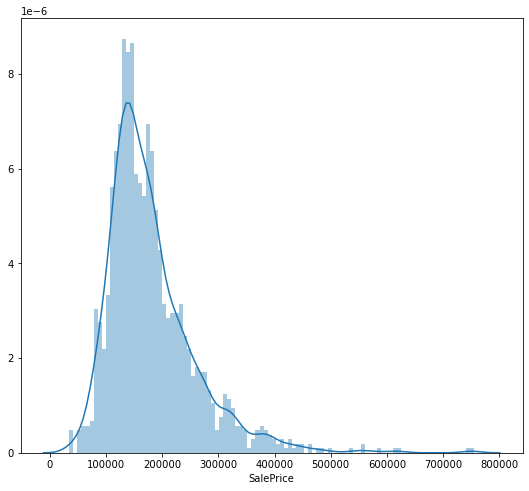

In [3]:
print('Sales price range in the training dataset: \n')
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'],  bins=100, hist_kws={'alpha': 0.4});

SalePrice is a slightly skewed distribution with a mean of $180,921. Now, let's investigate the independent variables more.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Clearly, some of these variables are highly correlated. For example, you cannot have a PoolQC, pool quality, without a PoolArea. Before we can look at correlation graphically, we need to clean the data so that all features are represented numerically. We will do so below.

Also, 79 independent variables is quite sizeable. This set looks ideal for PCA. Before, we begin to implement PCA, let's drop the columns with approximately 50% or more missing values. Imputing that many null values would likely skew our results. Additionally, we will remove Id since that is an arbitrary factor used for house identification only.  

In [5]:
train_df = train_df.drop(columns = ['MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley','Id'])
train_df.info()                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

PCA will not work with object datatypes. We need to change each of those columns into numberical values using numbers to represent categories.

In [6]:
for c in train_df.columns:
    if train_df[c].dtype == object:
        print(c, train_df[c].unique())

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street ['Pave' 'Grvl']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkF

In [7]:
train_df = train_df.replace({'MSZoning' : {'RL' : 1, 'RM' : 2, 'C (all)' : 3, 'FV' : 4, 'RH' : 5}})
train_df = train_df.replace({'Street' : {'Pave' : 1, 'Grvl' : 2}})
train_df = train_df.replace({'LotShape' : {'Reg' : 1, 'IR1' : 2, 'IR2' : 3, 'IR3' : 4}})
train_df = train_df.replace({'LandContour' : {'Lvl' : 1, 'Bnk' : 2, 'Low' : 3, 'HLS' : 4}})
train_df = train_df.replace({'Utilities' : {'AllPub' : 1, 'NoSeWa' : 2}})
train_df = train_df.replace({'LotConfig' : {'Inside' : 1, 'FR2' : 2, 'Corner' : 3, 'CulDSac' : 4, 'FR3' : 5}})
train_df = train_df.replace({'LandSlope' : {'Gtl' : 1, 'Mod' : 2, 'Sev' : 3}})
train_df = train_df.replace({'Neighborhood' : {'CollgCr' : 1, 'Veenker' : 2, 'Crawfor' : 3, 'NoRidge' : 4, 'Mitchel' : 5,
                                              'Somerst' : 6, 'NWAmes' : 7, 'OldTown' : 8, 'BrkSide' : 9, 'Sawyer' : 10,
                                              'NridgHt' : 11, 'NAmes' : 12, 'SawyerW' : 13, 'IDOTRR' : 14,
                                              'MeadowV' : 15, 'Edwards' : 16, 'Timber' : 17, 'Gilbert' : 18,
                                              'StoneBr' : 19, 'ClearCr' : 20, 'NPkVill' : 21, 'Blmngtn' : 22,
                                              'BrDale' : 23, 'SWISU' : 24, 'Blueste' : 25}})
train_df = train_df.replace({'Condition1' : {'Norm' : 1, 'Feedr' : 2, 'PosN' : 3, 'Artery' : 4, 'RRAe' : 5,
                                            'RRNn' : 6, 'RRAn' : 7, 'PosA' : 8, 'RRNe' : 9}})
train_df = train_df.replace({'Condition2' : {'Norm' : 1, 'Artery' : 2, 'RRNn' : 3, 'Feedr' : 4, 'PosN' : 5,
                                            'PosA' : 6, 'RRAn' : 7, 'RRAe' : 8}})
train_df = train_df.replace({'BldgType' : {'1Fam' : 1, '2fmCon' : 2, 'Duplex' : 3, 'TwnhsE' : 4, 'Twnhs' : 5}})
train_df = train_df.replace({'HouseStyle' : {'2Story' : 1, '1Story' : 2, '1.5Fin' : 3, '1.5Unf' : 4, 'SFoyer' : 5,
                                            'SLvl' : 6, '2.5Unf' : 7, '2.5Fin' : 8}})
train_df = train_df.replace({'RoofStyle' : {'Gable' : 1, 'Hip' : 2, 'Gambrel' : 3, 'Mansard' : 4, 'Flat' : 5,
                                            'Shed' : 6}})
train_df = train_df.replace({'RoofMatl' : {'CompShg' : 1, 'WdShngl' : 2, 'Metal' : 3, 'WdShake' : 4, 'Membran' : 5,
                                            'Tar&Grv' : 6, 'Roll' : 7, 'ClyTile' : 8}})
train_df = train_df.replace({'Exterior1st' : {'VinylSd' : 1, 'MetalSd' : 2, 'Wd Sdng' : 3, 'HdBoard' : 4, 'BrkFace' : 5,
                                            'WdShing' : 6, 'CemntBd' : 7, 'Plywood' : 8, 'AsbShng' : 9,
                                             'Stucco' : 10, 'BrkComm' : 11, 'AsphShn' : 12, 'Stone' : 13,
                                             'ImStucc' : 14, 'CBlock' : 15}})
train_df = train_df.replace({'Exterior2nd' : {'VinylSd' : 1, 'MetalSd' : 2, 'Wd Shng' : 3, 'HdBoard' : 4, 'Plywood' : 5,
                                            'Wd Sdng' : 6, 'CmentBd' : 7, 'BrkFace' : 8, 'Stucco' : 9,
                                             'AsbShng' : 10, 'Brk Cmn' : 11, 'ImStucc' : 12, 'AsphShn' : 13,
                                             'Stone' : 14, 'Other' : 15, 'CBlock' : 16}})
train_df = train_df.replace({'MasVnrType' : {'BrkFace' : 1, 'None' : 2, 'Stone' : 3, 'BrkCmn' : 4}})
train_df = train_df.replace({'ExterQual' : {'Gd' : 1, 'TA' : 2, 'Ex' : 3, 'Fa' : 4}})
train_df = train_df.replace({'ExterCond' : {'TA' : 1, 'Gd' : 2, 'Fa' : 3, 'Po' : 4, 'Ex' : 5}})
train_df = train_df.replace({'Foundation' : {'PConc' : 1, 'CBlock' : 2, 'BrkTil' : 3, 'Wood' : 4, 'Slab' : 5,
                                            'Stone' : 6}})
train_df = train_df.replace({'BsmtQual' : {'Gd' : 1, 'TA' : 2, 'Ex' : 3, 'Fa' : 4}})
train_df = train_df.replace({'BsmtCond' : {'Gd' : 1, 'TA' : 2, 'Po' : 3, 'Fa' : 4}})
train_df = train_df.replace({'BsmtExposure' : {'No' : 1, 'Gd' : 2, 'Mn' : 3, 'Av' : 4}})
train_df = train_df.replace({'BsmtFinType1' : {'GLQ' : 1, 'ALQ' : 2, 'Unf' : 3, 'Rec' : 4, 'BLQ' : 5, 'LwQ' : 6}})
train_df = train_df.replace({'BsmtFinType2' : {'GLQ' : 1, 'ALQ' : 2, 'Unf' : 3, 'Rec' : 4, 'BLQ' : 5, 'LwQ' : 6}})
train_df = train_df.replace({'Heating' : {'GasA' : 1, 'GasW' : 2, 'Grav' : 3, 'Wall' : 4, 'OthW' : 5, 'Floor' : 6}})
train_df = train_df.replace({'HeatingQC' : {'Gd' : 1, 'TA' : 2, 'Ex' : 3, 'Fa' : 4, 'Po' : 5}})
train_df = train_df.replace({'CentralAir' : {'Y' : 1, 'N' : 2}})
train_df = train_df.replace({'Electrical' : {'SBrkr' : 1, 'FuseF' : 2, 'FuseA' : 3, 'FuseP' : 4, 'Mix' : 5}})
train_df = train_df.replace({'KitchenQual' : {'Gd' : 1, 'TA' : 2, 'Ex' : 3, 'Fa' : 4}})
train_df = train_df.replace({'Functional' : {'Typ' : 1, 'Min1' : 2, 'Maj1' : 3, 'Min2' : 4, 'Mod' : 5,
                                            'Maj2' : 6, 'Sev' : 7}})
train_df = train_df.replace({'GarageType' : {'Attchd' : 1, 'Detchd' : 2, 'BuiltIn' : 3, 'CarPort' : 4, 'Basment' : 5,
                                            '2Types' : 6}})
train_df = train_df.replace({'GarageFinish' : {'RFn' : 1, 'Unf' : 2, 'Fin' : 3}})
train_df = train_df.replace({'GarageQual' : {'Gd' : 1, 'TA' : 2, 'Ex' : 3, 'Fa' : 4, 'Po' : 5}})
train_df = train_df.replace({'GarageCond' : {'Gd' : 1, 'TA' : 2, 'Ex' : 3, 'Fa' : 4, 'Po' : 5}})
train_df = train_df.replace({'PavedDrive' : {'Y' : 1, 'N' : 2, 'P' : 3}})
train_df = train_df.replace({'SaleType' : {'WD' : 1, 'New' : 2, 'COD' : 3, 'ConLD' : 4, 'ConLI' : 5,
                                            'CWD' : 6, 'ConLw' : 7, 'Con' : 8, 'Oth' : 9}})
train_df = train_df.replace({'SaleCondition' : {'Normal' : 1, 'Abnorml' : 2, 'Partial' : 3, 'AdjLand' : 4, 'Alloca' : 5, 'Family' : 6}})
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

Now we have a dataset of 75 variables which are all numerical, either float64 or int64. This is still a large number of features. To visulaize these further, let's look at each feature's distribution.

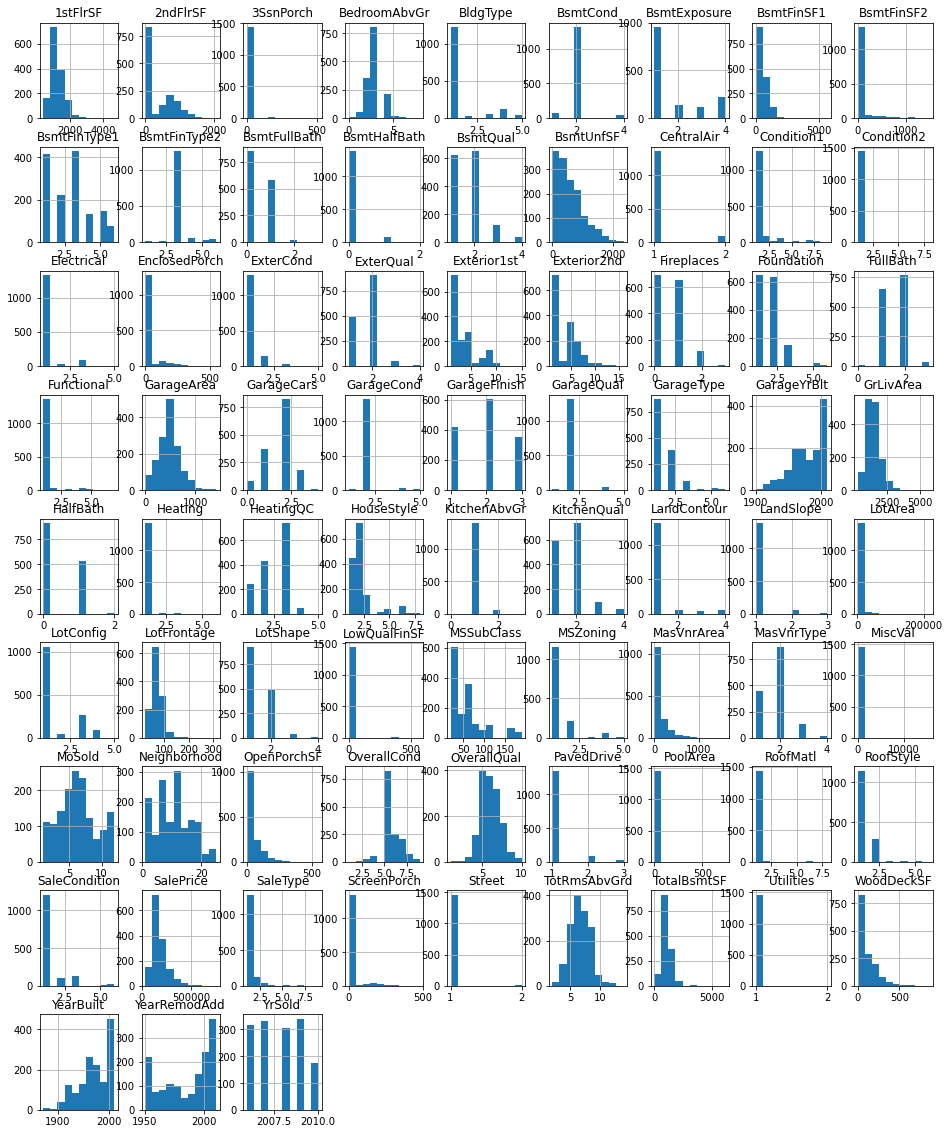

In [8]:
train_df.hist(figsize=(16, 20)) 
plt.show()

To perform PCA, we need to impute values for the null entries. Those columns with null values are

In [9]:
may_impute = []
for c in train_df.columns:
    if train_df[c].isnull().sum() != False:
        may_impute.append(c)
print(may_impute)

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


In [10]:
for c in may_impute: 
    print(c, train_df[c].mean())

LotFrontage 70.04995836802665
MasVnrType 1.8023415977961432
MasVnrArea 103.68526170798899
BsmtQual 1.6999297259311315
BsmtCond 2.0189739985945185
BsmtExposure 1.7208157524613221
BsmtFinType1 2.7153900210822206
BsmtFinType2 3.148382559774965
Electrical 1.1562714187799863
GarageType 1.504713560551124
GarageYrBlt 1978.5061638868744
GarageFinish 1.9492385786802031
GarageQual 2.0681653372008704
GarageCond 2.0609137055837565


We are choosing to use the mean for the float64 datatypes and the rounded mean for int64 datatypes. 

In [11]:
values = {"LotFrontage": 70, "MasVnrType": 1.8, "MasVnrArea": 103.7, "BsmtQual": 2, "BsmtCond": 2, 
          "BsmtExposure": 2, "BsmtFinType1": 3, "BsmtFinType2": 3, "Electrical": 1,
         "GarageType": 1.5, "GarageYrBlt": 1978.5, "GarageFinish": 1.9,
         "GarageQual": 2, "GarageCond": 2} 
train_df.fillna(value=values, inplace = True)
for i in train_df:
    if train_df[i].isnull().values.any() == True:
        print("There is a nan in ", i, " column.")

Now that the we have eliminated null values, let's look to see if there is a visual difference in their distributions. 

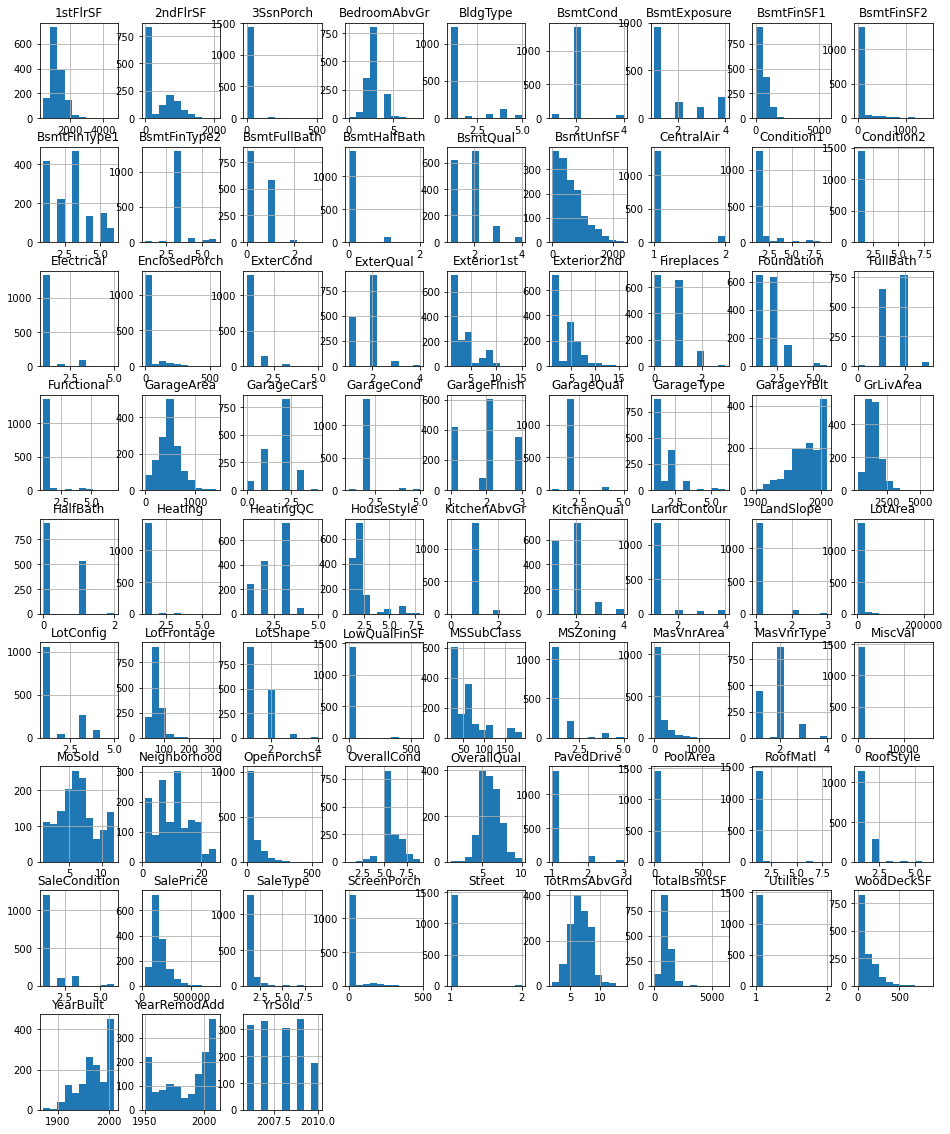

In [12]:
train_df.hist(figsize=(16, 20)) 
plt.show()

Those are a lot of histograms to consider. Only the 14 with imputed values needed to be compared from the first set. Visually, there does not seem to be a change in any of the distributions. 

Before moving on to modeling, let's confirm our suspicions about correlated features now that all datatypes are either float64 or int64.

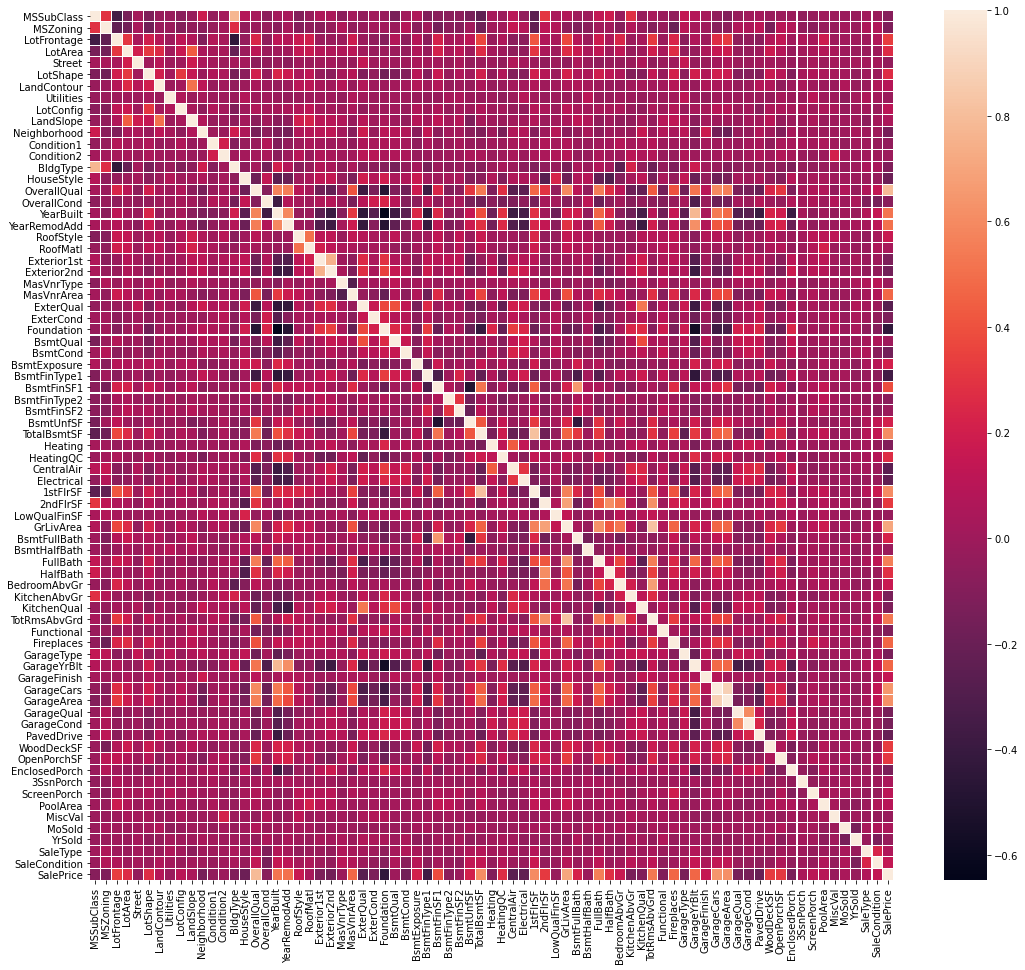

In [13]:
plt.figure(figsize=(18,16))
sns.heatmap(train_df.corr(),linewidth=.1) 

With 74 remaining featrues, the correlation heat map would be very hard to read if we included the correlation coefficients for each pair. We do see plenty of light and dark spots in the heat map, indicating highly correlated variables, like GarageCars and GarageArea. Now, we are ready to build our model.

## Analysis

We are now ready to move on to splitting the training dataset using sklearn.

In [14]:
X = train_df.drop('SalePrice',1)
y = train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

With 74 features to consider, it's hard to randomly pick a number between 1-74 in which to run PCA. Let's create a loop where we consider all options and see how much variance is captured with each round of differing number of components.

In [15]:
for i in range(1,75):
    model_loop = PCA(n_components = i, random_state = 2)
    X_train_loop = model_loop.fit_transform(X_train)
    X_test_loop = model_loop.transform(X_test)
    print("For", i, "components, the explained variance is ", (model_loop.explained_variance_ratio_.sum()))

For 1 components, the explained variance is  0.9871994232882638
For 2 components, the explained variance is  0.9919709326525398
For 3 components, the explained variance is  0.9950992004185756
For 4 components, the explained variance is  0.9976554327632179
For 5 components, the explained variance is  0.9984414552872938
For 6 components, the explained variance is  0.9989100928855571
For 7 components, the explained variance is  0.9992063868071863
For 8 components, the explained variance is  0.9994810410715076
For 9 components, the explained variance is  0.999699047369702
For 10 components, the explained variance is  0.9998272782180745
For 11 components, the explained variance is  0.9998634336357615
For 12 components, the explained variance is  0.9998935854252439
For 13 components, the explained variance is  0.9999212466966444
For 14 components, the explained variance is  0.9999461658126774
For 15 components, the explained variance is  0.9999628854017822
For 16 components, the explained va

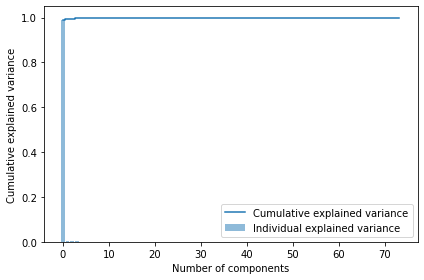

In [16]:
pca = PCA(random_state = 2)
X_train_pca = pca.fit_transform(X_train)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

It seems unlikely that out of 74 features, only one component is needed for it captures nearly all of the variance. So, what went wrong? These features use different units of measurement. Some are continuous while others are categorical. We need to normalize the features and we'll do so using sklearn's StandardScaler, then we will run PCA again on the normalized set.

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
for i in range(1,75):
    model_loop = PCA(n_components = i, random_state = 2)
    X_train_loop = model_loop.fit_transform(X_train)
    X_test_loop = model_loop.transform(X_test)
    print("For", i, "components, the explained variance is ", (model_loop.explained_variance_ratio_.sum()))

For 1 components, the explained variance is  0.12347193723322343
For 2 components, the explained variance is  0.18520263132440867
For 3 components, the explained variance is  0.23550564933796433
For 4 components, the explained variance is  0.27022285190526085
For 5 components, the explained variance is  0.302530384943025
For 6 components, the explained variance is  0.3287383495782729
For 7 components, the explained variance is  0.35342130148190753
For 8 components, the explained variance is  0.37542045208270935
For 9 components, the explained variance is  0.3974627769450941
For 10 components, the explained variance is  0.41753169198467377
For 11 components, the explained variance is  0.437762772743488
For 12 components, the explained variance is  0.45706596046884707
For 13 components, the explained variance is  0.4750283875371092
For 14 components, the explained variance is  0.4939480407605077
For 15 components, the explained variance is  0.5113016325657402
For 16 components, the expla

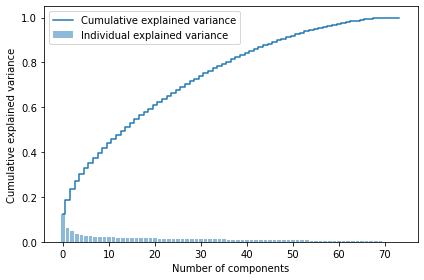

In [19]:
pca = PCA(random_state = 2)
X_train_pca = pca.fit_transform(X_train)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

This new explained variance curve is far more intuitive. It makes sense that many features are needed to predict house sales prices, otherwise we would all be in the real estate market. Unfortunealy, PCA shows us that we still need many features for prediction. Depending on our cut-off threshold: If we are content with 80% of explained variance, then we still need 37 features in our model. If we need to cover more explained variance like 99%, then PCA hardly reduces the dimensionality at all. 

## Results

Now that we have some reduction in PCA, let's look at how accurate of a prediction we get for varying number of components when using a Random Forest Classifier after PCA reduction.

In [20]:
accuracy_storage =[]
for i in range(1,75):
    pca_for_pred = PCA(n_components=i, random_state = 2)
    X_train_for_pred = pca_for_pred.fit_transform(X_train)
    X_test_for_pred = pca_for_pred.transform(X_test)

    classifier = RandomForestClassifier(max_depth=2, random_state=2)
    classifier.fit(X_train_for_pred, y_train)

    y_pred = classifier.predict(X_test_for_pred)
    accuracy_storage.append(accuracy_score(y_test, y_pred))


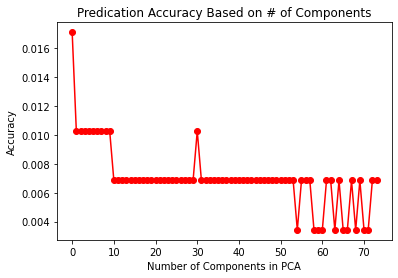

In [21]:
plt.plot(accuracy_storage, 'o-r')
plt.title('Predication Accuracy Based on # of Components')
plt.ylabel('Accuracy')
plt.xlabel('Number of Components in PCA')
plt.show()

Regardless of how many components we use for PCA, RandomForestClassifier does not yield very accurate results with a max_depth of 2. Let's hold the number of components constant at 37 as that covers 80% of the explained variance and change the max_depth of the RandomForestClassifier.

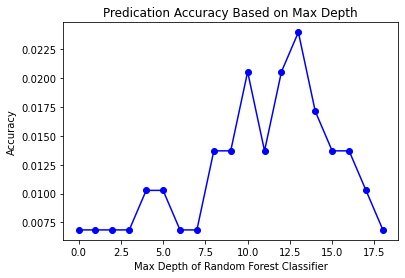

In [23]:
thirtyseven_storage =[]
pca_for_pred = PCA(n_components=37, random_state=2)
X_train_for_pred = pca_for_pred.fit_transform(X_train)
X_test_for_pred = pca_for_pred.transform(X_test)
for i in range(1,20):
    classifier = RandomForestClassifier(max_depth=i, random_state=2)
    classifier.fit(X_train_for_pred, y_train)
    y_pred = classifier.predict(X_test_for_pred)
    thirtyseven_storage.append(accuracy_score(y_test, y_pred))
plt.plot(thirtyseven_storage, 'o-b')
plt.title('Predication Accuracy Based on Max Depth')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth of Random Forest Classifier')
plt.show()

Accuracy improved only slightly compared to the values found by changing the number of components. The best combination looks to be using PCA with 37 components and Random Forest Classifier using a max depth of 13. 

In [33]:
pca_for_pred = PCA(n_components=37, random_state=2)
X_train_for_pred = pca_for_pred.fit_transform(X_train)
X_test_for_pred = pca_for_pred.transform(X_test)

classifier = RandomForestClassifier(max_depth=13, random_state=2)
classifier.fit(X_train_for_pred, y_train)

y_pred = classifier.predict(X_test_for_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
0.02054794520547945


Instead of the Random Forest classificaiton method, let's look at using Principal Compenent Regression (PCR) and Partial Least Squares Regression (PLS).$^1$ In class, it was noted that PCR can be difficult to interpret so for the ease of viewing, we will keep the PCA components to one. 

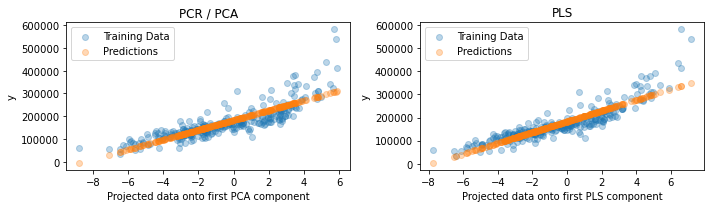

In [34]:
pcr = make_pipeline(StandardScaler(), PCA(n_components=1, random_state=2), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="Training Data")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="Predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="Training Data")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="Predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

As with Random Forest Classifier, both PCR and PLS do not fit the data well. 

## Conclusion

PCA helps reduce dimensionality, but this paper demonstrates that it may not be useful for all higher dimension datasets. The smoothness of the explained variance curve after normalization indicates that in spite of using PCA, a high number of features need to be kept in order to cover a sufficient amount of cumulative explained variance. This may be attributed to the vast differences in personal tastes and preferences amongest home buyers.  

## Reference

$^1$ Lars Buitinck and Gilles Louppe and Mathieu Blondel and Fabian Pedregosa and Andreas Mueller
and Olivier Grisel and Vlad Niculae and Peter Prettenhofer and Alexandre Gramfort and Jaques
Grobler and Robert Layton and Jake VanderPlas and Arnaud Joly and Brian Holt and Ga{”{e}}l
Varoquaux, {API} design for machine learning software: experiences from the scikit-learn project,
ECML PKDD Workshop: Languages for Data Mining and Machine Learning, 2013,  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-modelselection-train-test-split , https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA , https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression , https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler , https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression , https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier , https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix , 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy
.